In [15]:
import pandas as pd
df = pd.read_csv('apple_quality.csv').dropna()
df

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
...,...,...,...,...,...,...,...,...,...
3995,3995.0,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784369,bad
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good


In [10]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt

In [62]:
def f(x):
    return 1 / (1 + np.exp(-x))

def f_deriv(x):
    return f(x) * (1 - f(x))

def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l - 1]))
        b[l] = r.random_sample((nn_structure[l], ))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l - 1]))
        tri_b[l] = np.zeros((nn_structure[l], ))
    return tri_W, tri_b

def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        node_in = h[l]
        z[l + 1] = W[l].dot(node_in) + b[l]
        h[l + 1] = f(z[l + 1])
    return h, z

def calculate_out_layer_delta(y, h_out, z_out):
    return -(y - h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

def train_nn(nn_structure, X, y, iter_num = 3000, alpha = 0.5):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt % 1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0

        for i in range(len(y)):
            delta = {}
            h, z = feed_forward(X[i, :], W, b)

            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i, :], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i, :] - h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l + 1], W[l], z[l])
                        tri_W[l] += np.dot(delta[l + 1][:, np.newaxis], np.transpose(h[l][:, np.newaxis]))
                        tri_b[l] += delta[l + 1]

        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])

        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

def convert_y_to_vect(y, n_classes):
    y_vect = np.zeros((len(y), n_classes))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


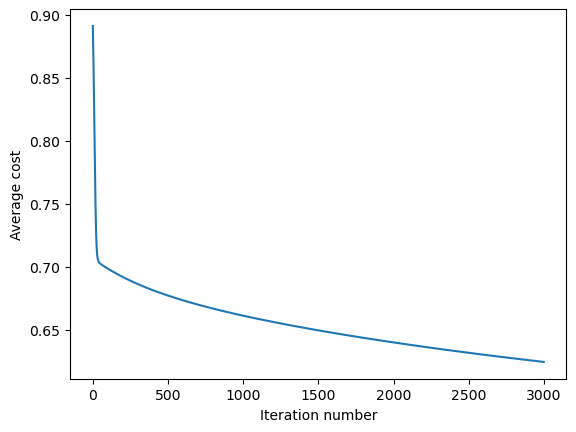

Prediction accuracy is 66.91666666666667%


In [64]:
y = df.iloc[:, -1].to_numpy()
y = np.where(y == 'good', 1, 0) 
X_scale = StandardScaler()
X = X_scale.fit_transform(df.iloc[:, 1:-1].to_numpy())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

y_v_train = convert_y_to_vect(y_train, 2)
y_v_test = convert_y_to_vect(y_test, 2)

nn_structure = [7, 30, 2]
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train)

plt.plot(avg_cost_func)
plt.ylabel('Average cost')
plt.xlabel('Iteration number')
plt.show()

y_pred = predict_y(W, b, X_test, len(nn_structure))
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))